In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15,8]
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split,KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [144]:
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [145]:
df.shape

(1000000, 8)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [147]:
df[['repeat_retailer', 'used_chip','used_pin_number', 'online_order']] = df[['repeat_retailer', 'used_chip','used_pin_number', 'online_order']].astype('object')

In [148]:
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [149]:
# There are no null values in the dataset

In [150]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


In [151]:
# Univariate Analysis

In [152]:
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

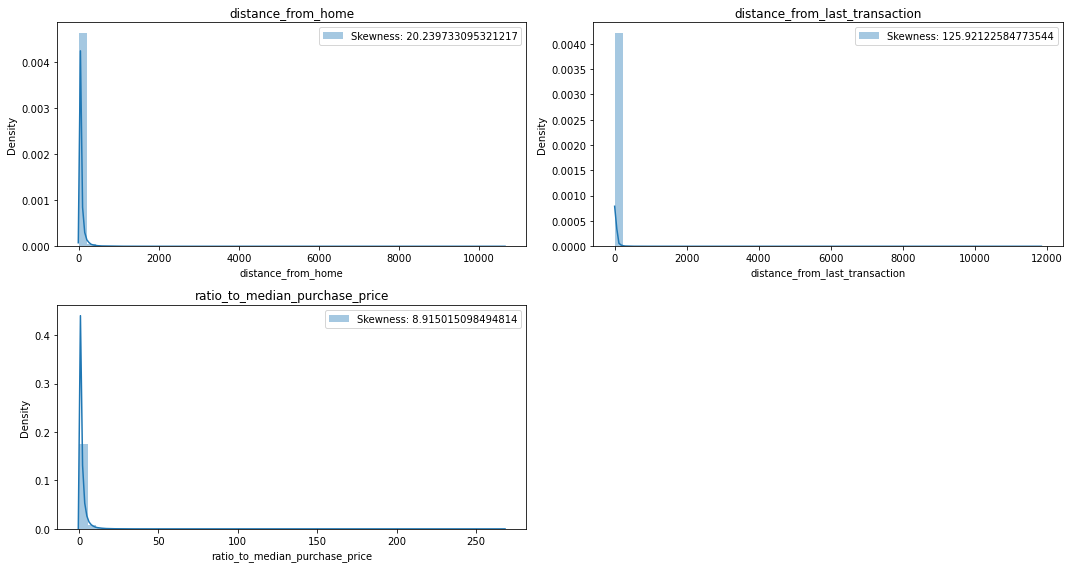

In [153]:
iteration = 1
for i in ['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']:
    plt.subplot(2,2,iteration)
    sns.distplot(df.loc[:,i],label= 'Skewness:'+' '+str(df[i].skew()))
    plt.title(i)
    plt.legend()
    iteration+=1
plt.tight_layout()
plt.show()

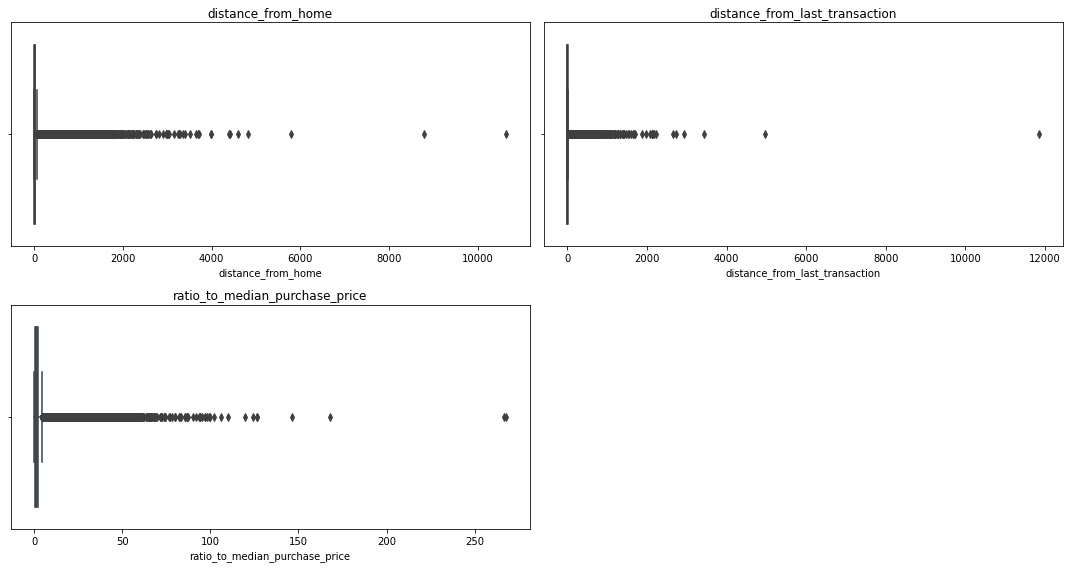

In [154]:
iteration = 1
for i in ['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']:
    plt.subplot(2,2,iteration)
    sns.boxplot(df.loc[:,i])
    plt.title(i)
    iteration+=1
plt.tight_layout()
plt.show()

In [155]:
# All the distributions are highly skewed

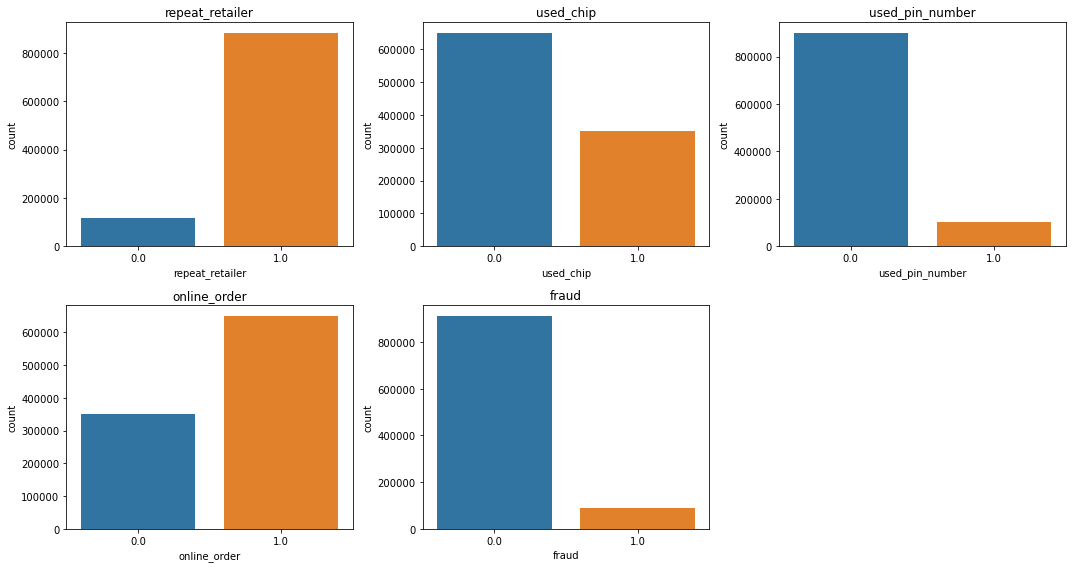

In [156]:
iteration = 1
for i in ['repeat_retailer', 'used_chip','used_pin_number', 'online_order', 'fraud']:
    plt.subplot(2,3,iteration)
    sns.countplot(df.loc[:,i])
    plt.title(i)
    iteration+=1
plt.tight_layout()
plt.show()

In [157]:
# Bivariate Analysis

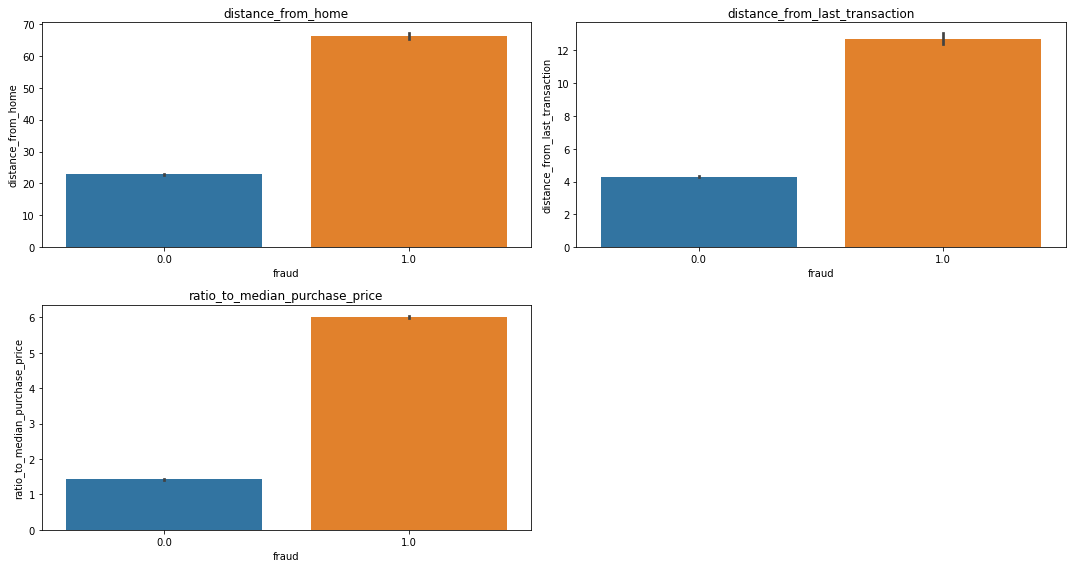

In [158]:
iteration = 1
for i in ['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']:
    plt.subplot(2,2,iteration)
    sns.barplot(x = df['fraud'],y=df[i])
    plt.title(i)
    iteration+=1
plt.tight_layout()
plt.show()

**Inference**
* As the transaction distance is increasing from the home no. of frauds are also more.
* Frauds are more as the transaction distance from last transaction is more.
* More frauds have seen in high ratio to mean purchase price.

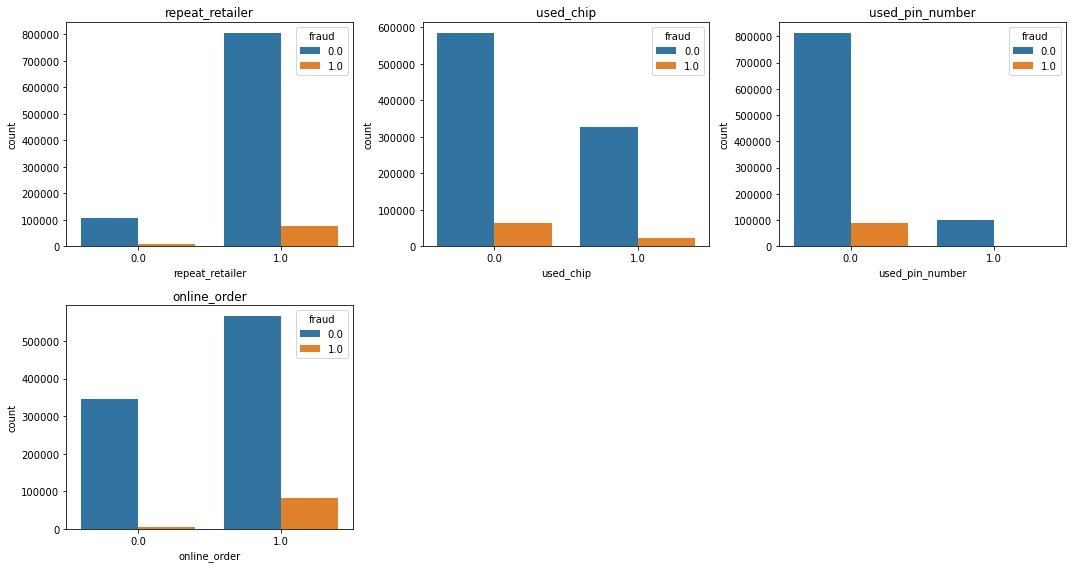

In [159]:
iteration = 1
for i in ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']:
    plt.subplot(2,3,iteration)
    sns.countplot(df.loc[:,i],hue=df['fraud'])
    plt.title(i)
    iteration+=1
plt.tight_layout()
plt.show()

**Inference**
* More frauds have observed in repaeat retailer
* More frauds have observed if the customer has not used the chip
* If the person is not using pin chances are fraud are more.
* Chances are fraud if the person is ordering online are more.

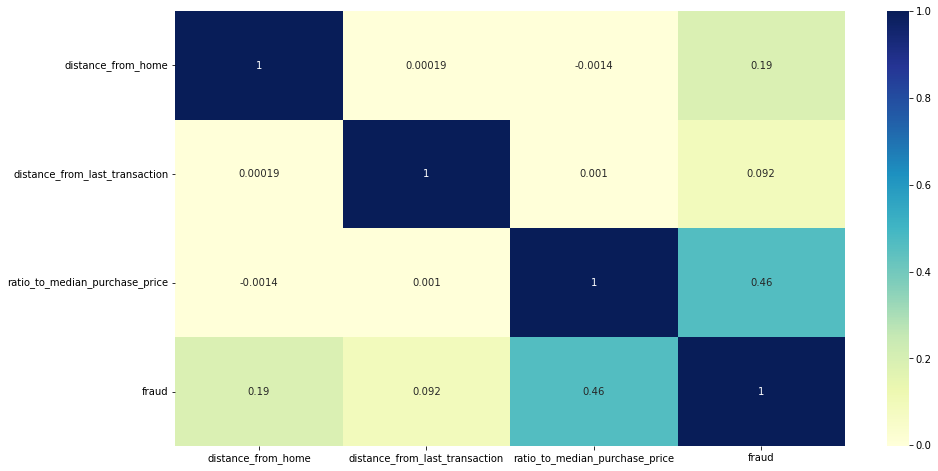

In [160]:
sns.heatmap(df.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [161]:
# Outlier Treatment using IQR method
q1 = df[['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']].quantile(0.25)
q3 = df[['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']].quantile(0.75)
iqr = q3-q1

ul = q3+1.5*iqr
ll = q1-1.5*iqr

trimmed_df = df[~((df[['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']]>ul) | (df[['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']]<ll)).any(axis=1)]


In [162]:
X = trimmed_df.drop('fraud',axis=1)
y = trimmed_df['fraud']

In [163]:
# train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.30,random_state=42)
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(503125, 7)
(503125,)
(215625, 7)
(215625,)


In [164]:
# Scaling
sc = StandardScaler()

In [165]:
for i in ['distance_from_home', 'distance_from_last_transaction','ratio_to_median_purchase_price']:
    Xtrain[i] = sc.fit_transform(Xtrain[[i]])
    Xtest[i] = sc.transform(Xtest[[i]])

In [166]:
# Model buliding
model_classification = DecisionTreeClassifier()
model_classification.fit(Xtrain,ytrain)
y_pred = model_classification.predict(Xtest)

In [168]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    212897
         1.0       1.00      1.00      1.00      2728

    accuracy                           1.00    215625
   macro avg       1.00      1.00      1.00    215625
weighted avg       1.00      1.00      1.00    215625



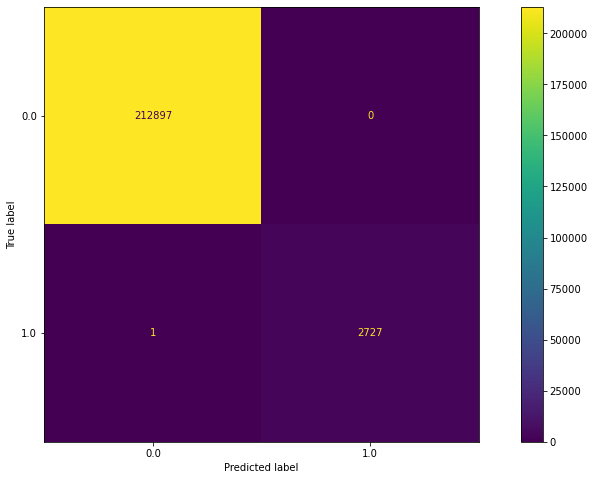

In [167]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(ytest,y_pred)
plt.show()

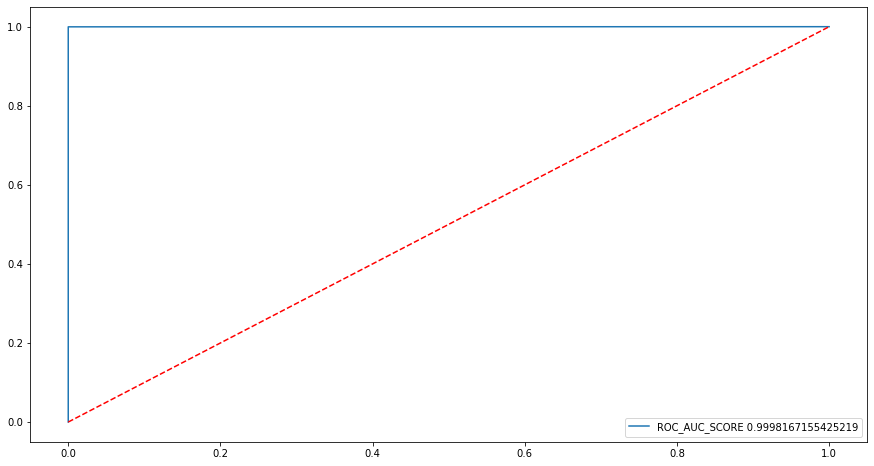

In [173]:
y_pred_proba = model_classification.predict_proba(Xtest)[:,1]
fpr,tpr,threshold = roc_curve(ytest,y_pred)
plt.plot(fpr,tpr,label= 'ROC_AUC_SCORE'+' '+str(roc_auc_score(ytest,y_pred_proba)))
plt.plot([0,1],[0,1],'r--')
plt.legend()
plt.show()

In [175]:
rfc = RandomForestClassifier()
rfc.fit(Xtrain,ytrain)
y_pred = rfc.predict(Xtest)
y_pred_proba = rfc.predict_proba(Xtest)[:,1]

In [176]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    212897
         1.0       1.00      1.00      1.00      2728

    accuracy                           1.00    215625
   macro avg       1.00      1.00      1.00    215625
weighted avg       1.00      1.00      1.00    215625



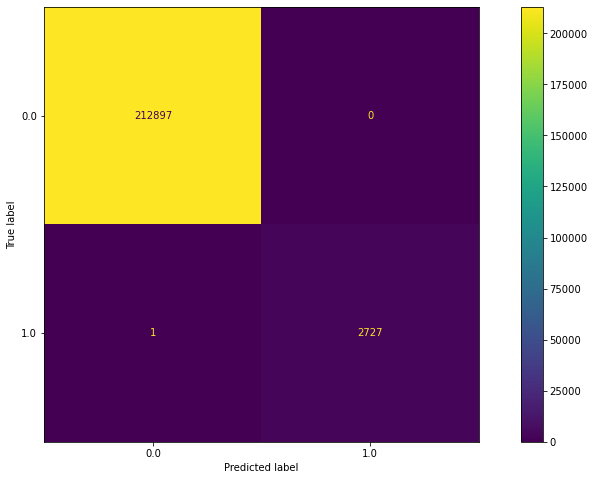

In [177]:
ConfusionMatrixDisplay.from_predictions(ytest,y_pred)
plt.show()

In [179]:
knn = KNeighborsClassifier()
knn.fit(Xtrain,ytrain)
y_pred = knn.predict(Xtest)

In [180]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    212897
         1.0       0.97      0.97      0.97      2728

    accuracy                           1.00    215625
   macro avg       0.99      0.99      0.99    215625
weighted avg       1.00      1.00      1.00    215625



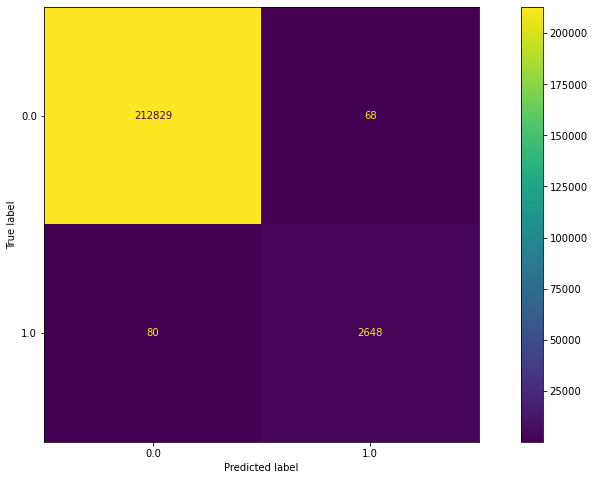

In [181]:
ConfusionMatrixDisplay.from_predictions(ytest,y_pred)
plt.show()

In [182]:
y_pred_proba = knn.predict_proba(Xtest)[:,1]

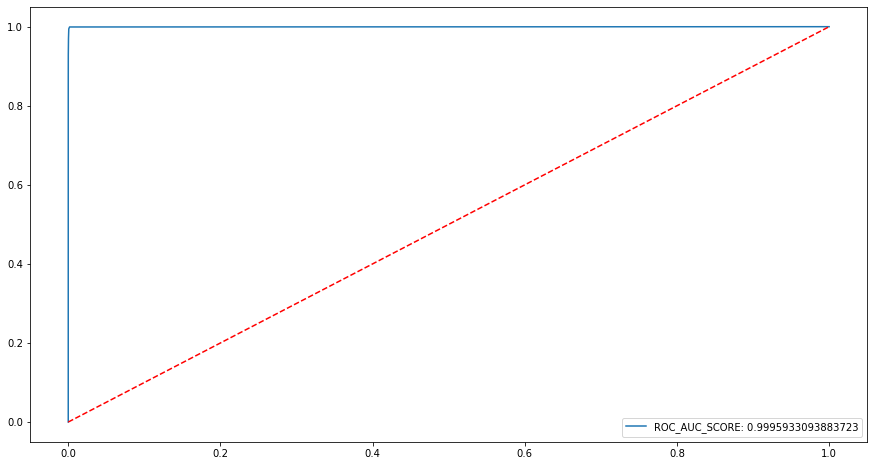

In [183]:
fpr,tpr,threshold = roc_curve(ytest,y_pred_proba)
plt.plot(fpr,tpr,label = 'ROC_AUC_SCORE:'+' '+str(roc_auc_score(ytest,y_pred_proba)))
plt.plot([0,1],[0,1],'r--')
plt.legend()
plt.show()